# Surface salinity flux correction

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import gsw
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.file_io import find_processed_cesm2_file
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.interpolation import extend_into_mask
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

# %load_ext line_profiler

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
sose_dir = f'{base_dir}B-SOSE/climatology/'

mesh_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze()
# domcfg    = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20250715.nc').squeeze()

In [21]:
ds_sose = xr.open_mfdataset(f'{sose_dir}SALT_climatology_202405_m*', combine='nested', concat_dim='month').isel(Z=0)
ds_sose['XC'] = fix_lon_range(ds_sose['XC'])
ds_sose = ds_sose.sortby('XC').rename({'XC':'lon','YC':'lat'})
ds_sose = ds_sose.assign({'month':np.arange(1,13)})

In [27]:
ds_sose.to_netcdf(f'{sose_dir}SALT_climatology_202405_combined.nc', unlimited_dims=['month'])

Processing steps needed:
- Combine monthly into single file
- Interpolate to surface value?? or just decide it's close enough
- Regrid to eANT025 grid
- Convert from practical salinity to absolute salinity
- Fill land with nearest ocean values

In [3]:
ds_sose_1 = xr.open_dataset(f'{sose_dir}eANT025_SOSE_PracSal_climatology.nc').drop_vars(['x','y']) # regridded to eANT025 grid

In [4]:
absS = gsw.SA_from_SP(ds_sose_1['PracSal'], 2.1, mesh_mask.nav_lon, mesh_mask.nav_lat)

In [13]:
# src_to_fill = xr.where(np.isnan(absS), -9999, absS) # which cells need to be filled
# src_to_fill = xr.where(mesh_mask.tmask.isel(nav_lev=0)!=0 * np.isnan(absS), -9999, absS)
src_to_fill = xr.where(absS<29, -9999, absS)
src_to_fill = xr.where(np.isnan(src_to_fill), -9999, src_to_fill)
var_filled  = extend_into_mask(src_to_fill.values, missing_val=-9999, fill_val=np.nan, use_2d=True, use_3d=False, num_iters=100)
ds_sose_2  = ds_sose_1.copy().drop_vars(['PracSal'])
ds_sose_2['AbsSal'] = (('month','y','x'), var_filled)

100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


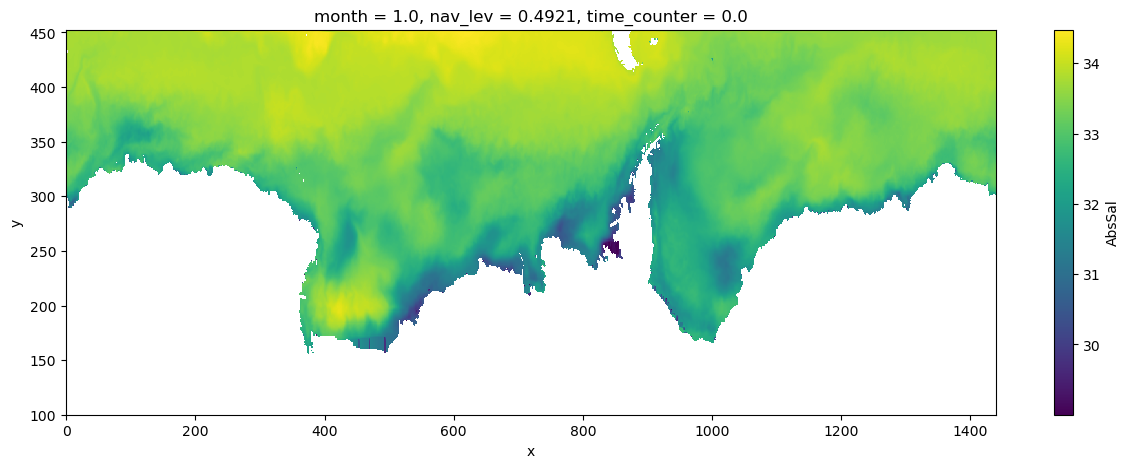

In [14]:
ds_sose_2.AbsSal.where(ds_sose_2.AbsSal > -100).where(mesh_mask.tmask.isel(nav_lev=0)!=0).isel(month=0).plot(figsize=(15,5), ylim=(100,None))

In [15]:
ds_sose_2['month'] = np.arange(1,13)

In [17]:
ds_sose_2.rename({'month':'time_counter'}).to_netcdf(f'{sose_dir}eANT025_SOSE_AbsSal_filled_climatology.nc', unlimited_dims=['time_counter'])